In [1]:
#!pip3 install catboost shap scikit-learn pandas matplotlib

AUC Score: 0.9983509389671361
F1 Score: 0.9953271028037384
Precision-Recall AUC: 0.9983081929904231


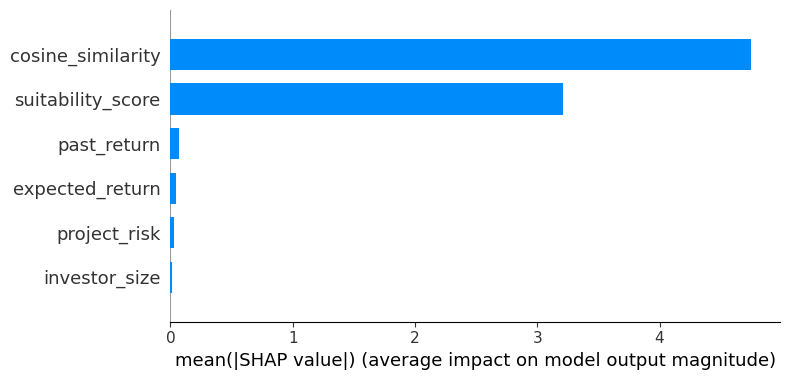

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc
import shap
import matplotlib.pyplot as plt
import joblib

# Load and split the dataset
def load_and_split_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Separate features and target
    X = df.drop(columns=["final_label"])
    y = df["final_label"]

    # Split the dataset: 60% training, 20% validation, 20% testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

    return X, y, X_train, X_val, X_test, y_train, y_val, y_test

# Train CatBoost and select important features
def train_and_select_features(X_train, y_train, cat_features):
    model = CatBoostClassifier(verbose=0, random_state=42)
    model.fit(X_train, y_train, cat_features=cat_features)
    importances = model.get_feature_importance()
    importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
    selected_features = importance_df[importance_df["Importance"] >= importance_df["Importance"].median()]["Feature"].tolist()
    return selected_features

# Retrain model using selected features
def retrain_model(X_train, y_train, selected_features, cat_features):
    cat_features_final = list(set(selected_features) & set(cat_features))
    model = CatBoostClassifier(verbose=0, random_state=42)
    model.fit(X_train[selected_features], y_train, cat_features=cat_features_final)
    return model, cat_features_final

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print("AUC Score:", auc_score)
    print("F1 Score:", f1)
    print("Precision-Recall AUC:", pr_auc)

# Interpret the model using SHAP
def interpret_model(model, X_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")

# Sample predictions for a specific investor
def sample_investor_predictions(model, X_test, key_feature, n=10):
    sample_val = X_test[key_feature].value_counts().idxmax()
    investor_rows = X_test[X_test[key_feature] == sample_val]
    sampled_rows = investor_rows.sample(n=n, random_state=42)
    scores = model.predict_proba(sampled_rows)[:, 1]
    sampled_rows = sampled_rows.copy()
    sampled_rows["proba_score"] = scores
    return sampled_rows.sort_values(by="proba_score", ascending=False)

# Save model and features
def save_artifacts(model, selected_features, cat_features):
    joblib.dump(model, "catboost_investment_model.pkl")
    joblib.dump(selected_features, "selected_features.pkl")
    joblib.dump(cat_features, "final_cat_features.pkl")

# Main execution
def main():
    categorical_features = [
        "investor_sector", "project_sector", "investor_location", "project_location",
        "investor_risk", "project_risk", "investor_size", "project_size"
    ]
    X, y, X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data("investment_suitability_dataset_balanced.csv")
    selected_features = train_and_select_features(X_train, y_train, categorical_features)
    model, cat_features_final = retrain_model(X_train, y_train, selected_features, categorical_features)
    evaluate_model(model, X_test[selected_features], y_test)
    interpret_model(model, X_test[selected_features])
    sampled = sample_investor_predictions(model, X_test[selected_features], key_feature="past_return", n=10)
    save_artifacts(model, selected_features, cat_features_final)
    return sampled

if __name__ == "__main__":
    output_df = main()
    output_df.head(5)

<Figure size 400x400 with 0 Axes>

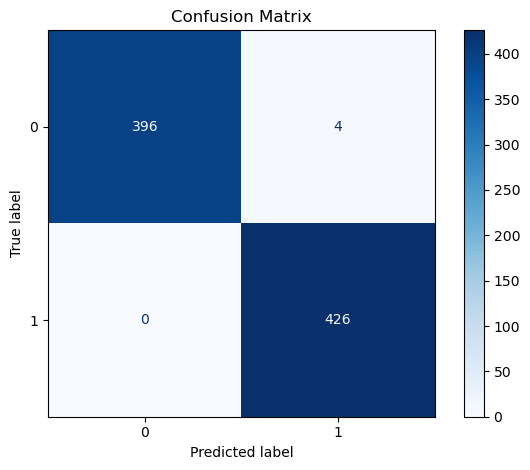

In [11]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, auc

# Load saved artifacts
model = joblib.load("catboost_investment_model.pkl")
selected_features = joblib.load("selected_features.pkl")
cat_features = joblib.load("final_cat_features.pkl")

# Load the dataset and prepare the test set
df = pd.read_csv("investment_suitability_dataset_balanced.csv")
X = df.drop(columns=["final_label"])
y = df["final_label"]

# Recreate the split to obtain test set
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_test_sel = X_test[selected_features]

# Get predictions and probabilities
y_pred = model.predict(X_test_sel)
y_pred_proba = model.predict_proba(X_test_sel)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(4, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
